# 3 - Benchmarking
This notebook explores the performance of the driftcorrection algorithm as defined in `2 - Driftcorrection` by benchmarking the time it takes to driftcorrected stacks of different numbers of images.

In [13]:
# Needed imports
from Registration import *
import shutil
import xarray as xr
import time
from dask.distributed import Client
import matplotlib.pyplot as plt

In [14]:
# temporary imports
from pyL5.lib.analysis.container import Container

In [15]:
# Get the data defined, but not loaded as we are using dask here.
folder = r'.\data\20171120_160356_3.5um_591.4_IVhdr'
original = Container(folder + '/data.h5').getStack('CPcorrected').getDaskArray()

.\data\20171120_160356_3.5um_591.4_IVhdr/data.h5


In [16]:
# Define a bunch of constants
fftsize = 256 // 2

Next, we define the grid of parameters for which we will perform the benchmark and the timings we want to save as an empty `xarray.DataArray`.

In [17]:
iters = np.arange(5)
sigmas = [3, 7, 9, 11, 13, 17]
#ns = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
#ns = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
#strides = np.arange(10,0,-1)
strides = np.array([15, 20, 35, 50, 70])
ts = [0,1,2,3,4]
res = xr.DataArray(np.zeros((len(iters), len(sigmas), len(strides), len(ts))), 
             coords={'i':iters, 'sigma': sigmas, 'strides': strides, 't': ts}, 
             dims=['i','sigma', 'strides', 't'])
res

<xarray.DataArray (i: 5, sigma: 6, strides: 5, t: 5)>
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]],


       ...,


       [[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]])
Coordinates:
  * i        (i) int32 0 1 2 3 4
  * sigma    (sigma) int32 3 7 9 11 13 17
  * strides  (strides) int32 15 20 35 50 70
  * t        (t) int32 0 1 2 3 4

Before we can start, we connect to the dask-scheduler and upload the used functions

In [ ]:
client = Client('localhost:8786')
client.upload_file('Registration.py')

In [19]:
tstart = time.time()
t = np.zeros((5,))
for p, stride in enumerate(strides):
    for sigma in sigmas:
        if p == 0:
            break
        for i in iters:
            t[0] = time.time()- tstart
            #start, stride, dE = 40, 1, 10
            start, stop, dE = 40, 740, 10
            #stop = start + n
            Eslice = slice(start, stop, stride)
            sliced_data = original[Eslice,...].rechunk({0:dE})
            sobel = crop_and_filter(sliced_data, 
                                    sigma=sigma, finalsize=2*fftsize)
            sobel = sobel - sobel.mean(axis=(1,2), keepdims=True)  
            Corr = dask_cross_corr(sobel)
            weights, argmax = max_and_argmax(Corr)
            Wc, Mc = calculate_halfmatrices(weights, argmax, fftsize=fftsize)
            t[1] = (time.time() - (t[0]+tstart))
            coords = np.arange(sliced_data)
            coords, weightmatrix, DX, DY, row_mask = threshold_and_mask(0.0, Wc, Mc, coords=coords)
            t[2] = (time.time() - (t[0]+tstart))
            dx, dy = calc_shift_vectors(DX, DY, weightmatrix)
            t[3] = (time.time() - (t[0]+tstart))
            shifts = np.stack(interp_shifts(coords, [dx, dy], n=sliced_data.shape[0]), axis=1)
            neededMargins = np.ceil(shifts.max(axis=0)).astype(int)
            shifts = da.from_array(shifts[..., np.newaxis], chunks=(dE,-1,1))
            corrected = da.map_blocks(shift_block, sliced_data, shifts,
                          margins=neededMargins,
                          dtype=sliced_data.dtype, 
                          chunks=(dE,
                                  sliced_data.shape[1] + neededMargins[0], 
                                  sliced_data.shape[2] + neededMargins[1]),
                         )
            corrected[:sliced_data.shape[0]].to_zarr(r'./tempresult.zarr', overwrite=True)
            t[4] = (time.time() - (t[0]+tstart))
            res.loc[dict(i=i,sigma=sigma,strides=stride)] = t
            shutil.rmtree(r'tempresult.zarr')
            print(t, corrected.shape, weights.shape)
    res.to_netcdf('benchmarkresult.nc')

DEBUG (0, 0, 0) (0, 0, 0)
DEBUG: dask.array<shift_block, shape=(40, 1311, 1055), dtype=uint16, chunksize=(10, 1311, 1055)> dask.array<sub, shape=(35, 256, 256), dtype=float64, chunksize=(10, 256, 256)>
[0.13232255 2.29535913 2.29535913 3.00712371 4.58247733] (40, 1311, 1055) (35, 35)
DEBUG (0, 0, 0) (0, 0, 0)
DEBUG: dask.array<shift_block, shape=(40, 1311, 1055), dtype=uint16, chunksize=(10, 1311, 1055)> dask.array<sub, shape=(35, 256, 256), dtype=float64, chunksize=(10, 256, 256)>
[4.72684407 2.25551248 2.25551248 2.69070172 4.1976974 ] (40, 1311, 1055) (35, 35)
DEBUG (0, 0, 0) (0, 0, 0)
DEBUG: dask.array<shift_block, shape=(40, 1311, 1055), dtype=uint16, chunksize=(10, 1311, 1055)> dask.array<sub, shape=(35, 256, 256), dtype=float64, chunksize=(10, 256, 256)>
[8.93657446 2.08054733 2.08054733 2.5297451  3.92245793] (40, 1311, 1055) (35, 35)
DEBUG (0, 0, 0) (0, 0, 0)
DEBUG: dask.array<shift_block, shape=(40, 1311, 1055), dtype=uint16, chunksize=(10, 1311, 1055)> dask.array<sub, shape=

## Plotting
Now we can plot the results using `xarray` plotting interface on the created datasets. First we do some cleaning up of the data and recombination:

In [9]:
highdata = xr.open_dataarray('benchmarkresult_jac_strided_high_count.nc')
lowdata = xr.open_dataarray('benchmarkresult_jac_strided_low_count.nc')
data = xr.concat([lowdata, highdata], dim='strides')

# We are interested in the times each individual step took, 
# instead of the time upto that step which is saved, so take a diff

data = xr.concat([data.isel(t=1), data.isel(t=slice(2,5)).diff(dim='t', label='lower'), data.isel(t=4)], 't')
data.attrs['long_name'] = 'Running time'
data.attrs['units'] = 's'

# Define a nicer 'Phase' dimension instead of 't'
data.coords['Phase'] = ('t', ['Filter+CC', 'Least Squares', 'Shift and write', 'Total']) 
data = data.swap_dims({'t': 'Phase'})
data.coords['N'] = ('strides', 700//data.coords['strides'])
data = data.swap_dims({'strides': 'N'})

And now we are ready to actually plot.

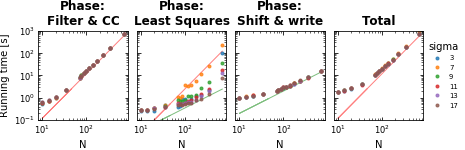

In [9]:
#Take the mean over the iterations
red = data.mean(dim='i', keep_attrs=True)

facetgrid = red.plot.line('.', col='Phase', hue='sigma', 
                          yscale='log', xscale='log', ylim=[0.1, 1000], 
                          figsize=[6,2], alpha=0.8)

# Add guidelines in red for quadratic in green for linear.
facetgrid.axes[0,0].plot(data['N'], 0.0012*data['N']**2, c='red', zorder=0, alpha=0.5)
facetgrid.axes[0,1].plot(data['N'], 0.00025*data['N']**2, c='red', zorder=0, alpha=0.5)
facetgrid.axes[0,1].plot(data['N'], 0.0035*data['N'], c='green', zorder=0, alpha=0.5)
facetgrid.axes[0,2].plot(data['N'], 0.02*data['N'], c='green', zorder=0, alpha=0.5)
facetgrid.axes[0,3].plot(data['N'], 0.0012*data['N']**2, c='red', zorder=0, alpha=0.5)
# Replace default plot titles with a somewhat nicer version
facetgrid.axes[0,0].set_title('Phase:\nFilter & CC')
facetgrid.axes[0,1].set_title('Phase:\nLeast Squares')
facetgrid.axes[0,2].set_title('Phase:\nShift & write')
facetgrid.axes[0,3].set_title('Total')
plt.subplots_adjust(top=0.8, bottom=0.18, left=0.08, wspace=0.1)
plt.savefig('timebench.pdf')